In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git
     

In [2]:
!pip install -q datasets

In [3]:
from datasets import load_dataset

dataset = load_dataset("hf-vision/road-pothole-segmentation")
     

/Users/daanbuseyne/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating validation split: 100%|███████| 5/5 [00:00<00:00, 2034.10 examples/s]


In [4]:

dataset
     

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 79
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 5
    })
})

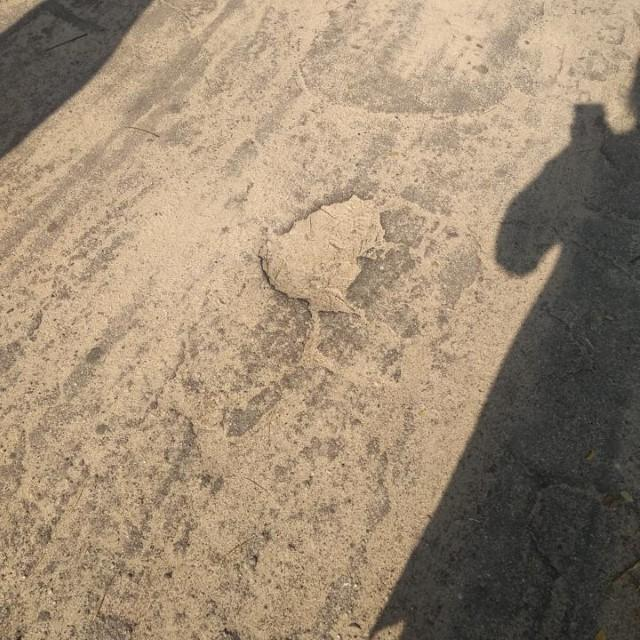

In [5]:
example = dataset["train"][1]
example
image = example["image"]
image    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 639.5, 639.5, -0.5)

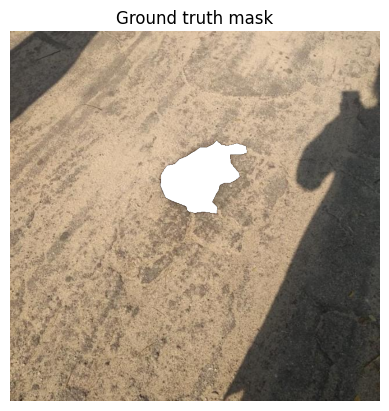

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [9]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)

  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox
     

In [10]:
import matplotlib.pyplot as plt

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

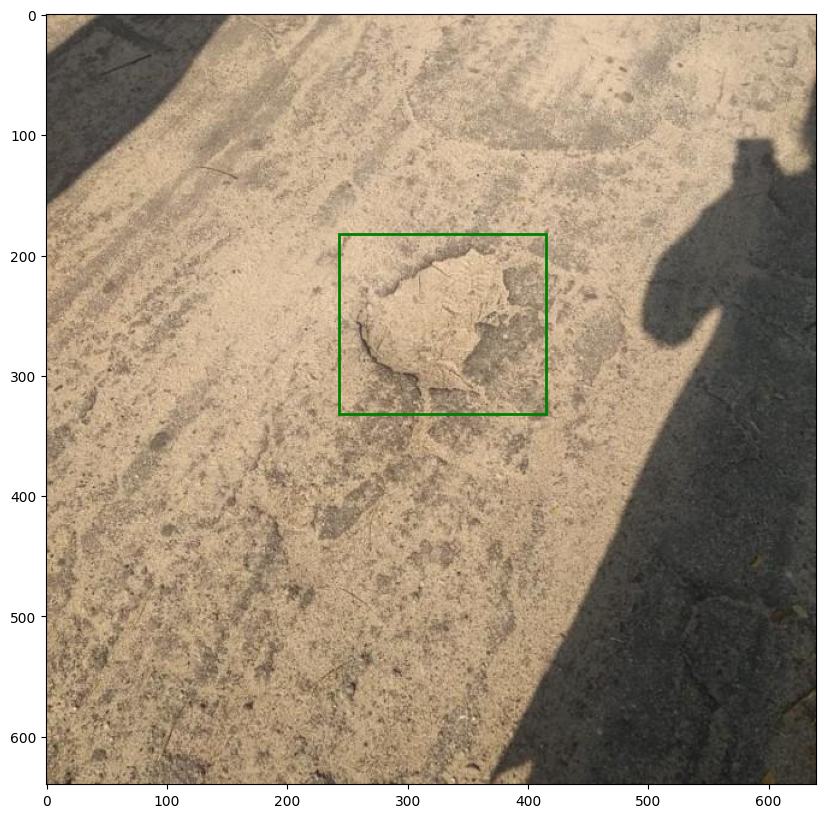

In [11]:
input_boxes = get_bounding_box(ground_truth_seg)
input_boxes
show_boxes_on_image(image, [input_boxes])
     

In [12]:
from torch.utils.data import Dataset
import cv2

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # normalize mask
    ground_truth_mask = ground_truth_mask / 255.0

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [13]:
from transformers import SamProcessor

# Load processor from official SAM
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [14]:
# Split dataset into training and validation
train_dataset = SAMDataset(dataset=dataset["train"], processor=processor)
validation_dataset = SAMDataset(dataset=dataset["validation"], processor=processor)

In [15]:
# Here we check shape from sample training dataset
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)
     

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (640, 640)


In [16]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [17]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 640, 640])


In [18]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [19]:

model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [20]:
from torch.optim import Adam
import torchvision

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

In [22]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch import nn


num_epochs = 4

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):

      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      predicted_masks = nn.functional.interpolate(predicted_masks,
                size=(640, 640),
                mode='bilinear',
                align_corners=False)

      ground_truth_masks = batch["ground_truth_mask"].float().to(device)

      loss = torchvision.ops.sigmoid_focal_loss(predicted_masks, ground_truth_masks.unsqueeze(1), reduction='mean')

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|███████████████████████████████████████████| 40/40 [08:42<00:00, 13.06s/it]


EPOCH: 0
Mean loss: 0.010186090518254786


100%|███████████████████████████████████████████| 40/40 [08:31<00:00, 12.78s/it]


EPOCH: 1
Mean loss: 0.006811571936123073


100%|███████████████████████████████████████████| 40/40 [09:02<00:00, 13.55s/it]


EPOCH: 2
Mean loss: 0.005813493358436972


100%|███████████████████████████████████████████| 40/40 [09:04<00:00, 13.61s/it]

EPOCH: 3
Mean loss: 0.005223651637788862


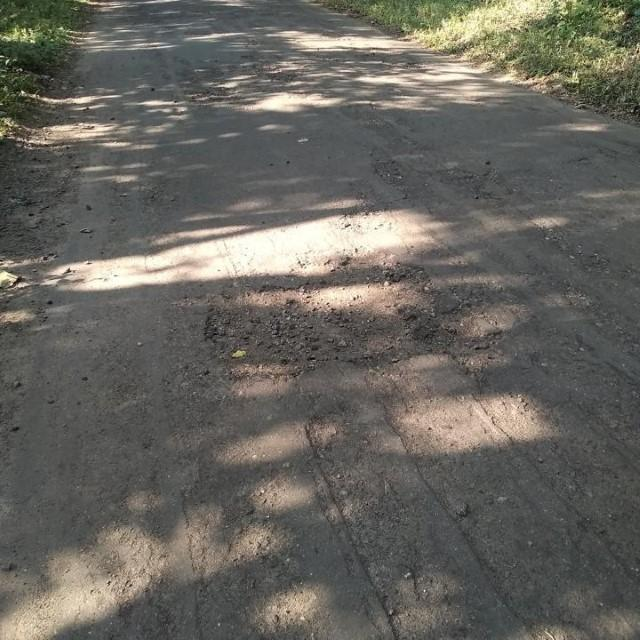

In [23]:
import numpy as np
from PIL import Image

# let's take a random validation example
idx = 4

# load image
image = dataset["validation"][idx]["image"]
image
     

In [24]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset["validation"][idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [25]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)
     

In [26]:
# apply sigmoid
sam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# resize masks to original
sam_seg_prob = nn.functional.interpolate(sam_seg_prob,
                size=(640, 640),
                mode='bilinear',
                align_corners=False)

# convert soft mask to hard mask
sam_seg_prob = sam_seg_prob.cpu().numpy().squeeze()
sam_segmentation_results = (sam_seg_prob > 0.5).astype(np.uint8)

In [27]:

sam_segmentation_results.shape

(640, 640)

In [28]:
ground_truth_mask.shape
     

(640, 640)

(-0.5, 639.5, 639.5, -0.5)

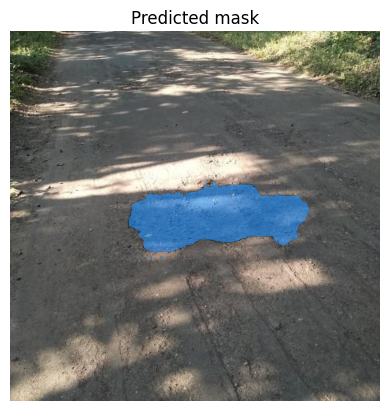

In [29]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(sam_segmentation_results, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 639.5, 639.5, -0.5)

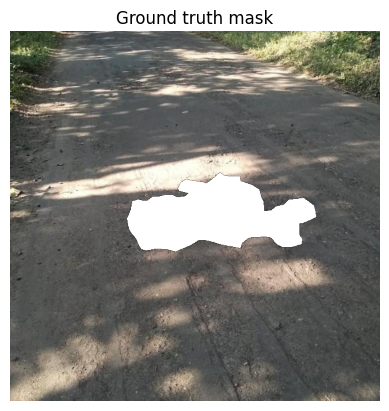

In [30]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")